In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np

import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

# RNN Class definition

In [3]:
x=np.load('BTCUSD.npy')
print(x)
#
# 1 minute data
#
# x[:,0] = open
# x[:,1] = high
# x[:,2] = low
# x[:,3] = close
# x[:,4] = volume

[[  54225.    54225.5   54171.5   54205.  2836315. ]
 [  54205.    54205.    54204.5   54204.5  437065. ]
 [  54204.5   54243.    54204.5   54234.5  750762. ]
 ...
 [  55081.5   55081.5   54933.5   55030.  7238913. ]
 [  55030.    55030.    54990.    55021.  1093417. ]
 [  55021.    55021.    55021.    55021.        0. ]]


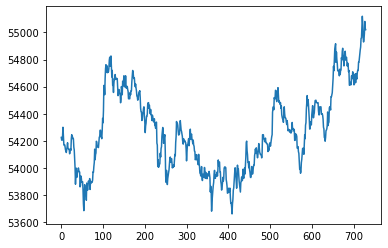

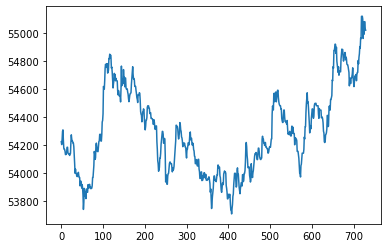

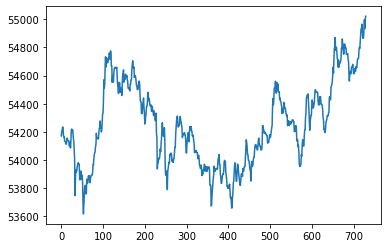

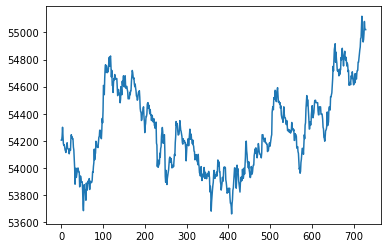

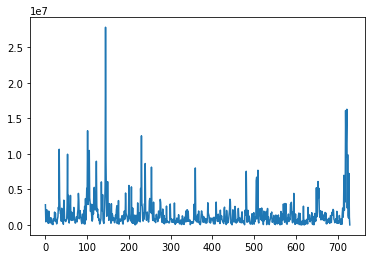

In [4]:
for i in range(x.shape[1]):
    plt.plot(x[:,i])
    plt.show()

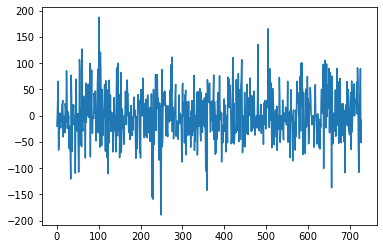

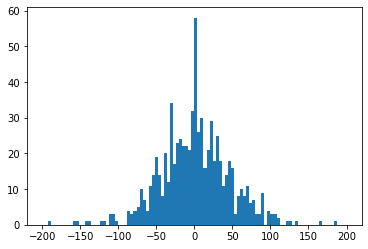

In [5]:
plt.plot(np.diff(x[:,0]))
plt.show()

plt.hist(np.diff(x[:,0]), bins=np.linspace(-200,200,101))
plt.show()

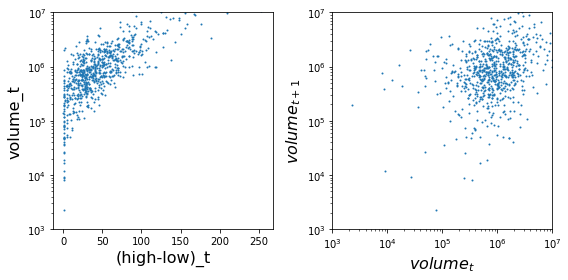

In [6]:
fig = plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(x[:,1]-x[:,2],x[:,-1],s=1)
plt.yscale('log')
plt.ylim(1e3,1e7)
plt.xlabel('(high-low)_t',fontsize=16)
plt.ylabel('volume_t',fontsize=16)

plt.subplot(1,2,2)
plt.scatter(x[:-1,-1],x[1:,-1],s=1)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e3,1e7)
plt.xlim(1e3,1e7)
plt.xlabel('$volume_t$',fontsize=16)
plt.ylabel('$volume_{t+1}$',fontsize=16)

plt.tight_layout()
plt.show()

In [7]:
y = np.zeros((x.shape[0]-1,2))
y[:,0] = x[:-1,-1]
y[:,1] = x[1:,-1]

mask = np.isnan(y[:,0]) | np.isnan(y[:,1])
y = y[~mask,:]

In [8]:
corr = np.corrcoef(y.T)
print(corr)

[[1.         0.40114816]
 [0.40114816 1.        ]]


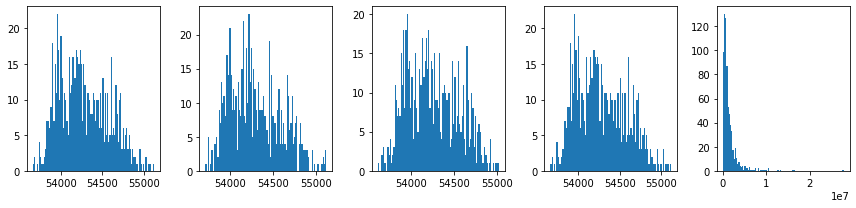

In [9]:
def PlotFeatures(x):
    fig = plt.figure(figsize=(12,3))

    for i in range(x.shape[1]):

        plt.subplot(1,x.shape[1],i+1)
        plt.hist(x[:,i],bins=101)

    plt.tight_layout()
    plt.show()
    
PlotFeatures(x)

In [10]:
def NormalizeFeatures(x):
    
#     P( a X + b < -1) = 0.1 => P( X  < -(1+b)/a ) = 0.1 => (1+b) = -q_0.1 a
#     P( a X + b < 1) = 0.9 => P( X  < (1-b)/a ) = 0.9 => (1-b) = q_0.9 a
    
#     2 = a(q_0.9-q_0.1) => a = 2/(q_0.9 - q_0.1)
#     b = 1 - q_0.9 a
    
    y = copy.copy(x)
    
    y[:,-1] = np.log(1+y[:,-1]/np.quantile(y[:,-1],0.5))
    
    for i in range(x.shape[1]):
        
        qtl = np.quantile(y[:,i], [0.1,0.9])
        a = 2/(qtl[1]-qtl[0])
        b = 1 - qtl[1] * a
        
        y[:,i] = a*y[:,i] + b
        
    return y

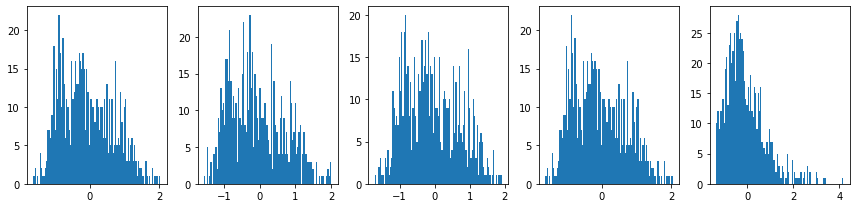

In [11]:
x_nrm = NormalizeFeatures(x)
PlotFeatures(x_nrm)

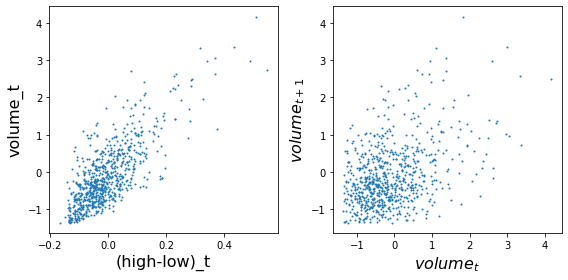

In [12]:
fig = plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(x_nrm[:,1]-x_nrm[:,2],x_nrm[:,-1],s=1)
plt.xlabel('(high-low)_t',fontsize=16)
plt.ylabel('volume_t',fontsize=16)

plt.subplot(1,2,2)
plt.scatter(x_nrm[:-1,-1],x_nrm[1:,-1],s=1)
plt.xlabel('$volume_t$',fontsize=16)
plt.ylabel('$volume_{t+1}$',fontsize=16)

plt.tight_layout()
plt.show()

In [13]:
class MyNet(nn.Module):
    
    def __init__(self, ni, hs, nl ):
        super(MyNet, self).__init__()
        
        # GRU layer
        self.GRU = nn.GRU(input_size=ni, hidden_size=hs, num_layers=nl)
        
        # GRU to output
        self.prop_h_to_out = nn.Linear(hs, 1)

    def forward(self, x):
        
        # input into  GRU layer (seq, batch, feature)
#         h_all, h_last = self.GRU(x)
        _, h_last = self.GRU(x)
        
        # GRU output to output layer
        y = self.prop_h_to_out(h_last)
        
        return y

In [14]:
def GrabBatch(t, n_series, x):
    
    X = torch.zeros((n_series, len(t), x.shape[1]))
    
    for i in range(len(t)):
        X[:,i,:] = torch.tensor(x[t[i]:t[i]+n_series,:]).float()
    
    return X

In [15]:
X = GrabBatch([1, 5, 300, 200, 31, 100], 10, x_nrm[:,-3:])
print(X.shape)
print(X)

torch.Size([10, 6, 3])
tensor([[[-0.1948, -0.2538, -0.7113],
         [-0.2608, -0.3176, -0.0668],
         [-0.5947, -0.4916, -0.3158],
         [-0.0602, -0.1136,  1.8064],
         [-0.5533, -0.5942,  0.7764],
         [ 0.1378,  0.2893,  1.3737]],

        [[-0.1948, -0.1787, -0.3696],
         [-0.2944, -0.3501, -0.7421],
         [-0.4394, -0.3376, -0.3352],
         [-0.0498,  0.0103,  0.2935],
         [-0.7241, -0.7656,  0.6092],
         [ 0.3669,  0.7586,  3.0487]],

        [[-0.1184, -0.0148,  0.6135],
         [-0.2944, -0.3376, -0.9953],
         [-0.3358, -0.3376, -0.2820],
         [ 0.0770,  0.0603, -0.2591],
         [-1.3776, -1.0672,  2.7270],
         [ 0.7513,  0.7373,  0.9587]],

        [[-0.1184, -0.1787,  0.2885],
         [-0.3734, -0.3727,  0.5039],
         [-0.2828, -0.2763, -0.8027],
         [ 0.1288,  0.1855, -0.0999],
         [-1.0347, -0.8745,  1.3590],
         [ 0.5998,  0.5872,  1.1893]],

        [[-0.2608, -0.3176, -0.0668],
         [-0.3798, 

In [16]:
net = MyNet(ni=3, hs=5, nl=4)

In [17]:
net.GRU(X)

(tensor([[[-0.0603,  0.1506, -0.1051,  0.1674,  0.0496],
          [-0.0626,  0.1535, -0.1041,  0.1667,  0.0487],
          [-0.0620,  0.1525, -0.1050,  0.1671,  0.0489],
          [-0.0686,  0.1614, -0.1008,  0.1647,  0.0469],
          [-0.0657,  0.1572, -0.1034,  0.1661,  0.0476],
          [-0.0674,  0.1602, -0.1003,  0.1646,  0.0477]],
 
         [[-0.1370,  0.2186, -0.1654,  0.2902,  0.0836],
          [-0.1405,  0.2228, -0.1643,  0.2895,  0.0827],
          [-0.1407,  0.2226, -0.1654,  0.2899,  0.0824],
          [-0.1554,  0.2417, -0.1544,  0.2842,  0.0786],
          [-0.1510,  0.2349, -0.1610,  0.2871,  0.0793],
          [-0.1597,  0.2483, -0.1477,  0.2802,  0.0786]],
 
         [[-0.2096,  0.2563, -0.1962,  0.3764,  0.1044],
          [-0.2078,  0.2547, -0.1995,  0.3778,  0.1058],
          [-0.2115,  0.2583, -0.1989,  0.3774,  0.1041],
          [-0.2300,  0.2832, -0.1828,  0.3695,  0.1000],
          [-0.2333,  0.2837, -0.1897,  0.3715,  0.0988],
          [-0.2432,  0.30

In [18]:
net(X)

tensor([[[-0.3996],
         [-0.3975],
         [-0.3644],
         [-0.4279],
         [-0.3006],
         [-0.3783]],

        [[-0.2164],
         [-0.2069],
         [-0.2346],
         [-0.2545],
         [-0.2736],
         [-0.3425]],

        [[-0.1571],
         [-0.1521],
         [-0.1588],
         [-0.1838],
         [-0.1626],
         [-0.2436]],

        [[-0.4733],
         [-0.4739],
         [-0.4716],
         [-0.4652],
         [-0.4796],
         [-0.4531]]], grad_fn=<AddBackward0>)